# BEATING CAPTCHAS

### Neural Network
- Don't usually support multiple values from a single neuron, instead preferring to have multiple outputs.

In [78]:
#
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pickle
import numpy as np

from matplotlib import pyplot as plt

### A. Letters IMAGES

In [3]:
with open("../../data/captchas/base-captchas/image", "rb") as f:
    inputs_ = pickle.load(f)
    
with open("../../data/captchas/base-captchas/targets", "rb") as f:
    targets = pickle.load(f)


Letter 11


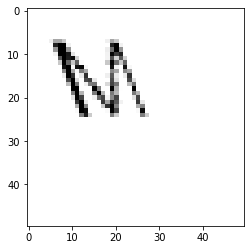

In [4]:
print(f"Letter {targets[0]}")
plt.imshow(inputs_[0], cmap='Greys')

In [5]:
inputs_ = np.array(inputs_, dtype='float')
onehot = OneHotEncoder()
out_put = onehot.fit_transform(np.array(targets).reshape(len(targets), 1))
out_put = np.array(out_put.todense())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(inputs_, out_put, train_size=0.9)

In [7]:
X_train.shape

(2700, 50, 50)

# Predict single letter in the image

### Convolutional Neural Network

- A brief about cnn,
- what's a convolutional layer?
- what's maxpooling layer?
- what's dropout?
- define flattening..


- Does higher values of strides will accelerate the training phase ? (Because we are moving faster arround pixels)

In [14]:
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential

import time
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (50, 50, 1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 50, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(25, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model

tensorboard = TensorBoard(log_dir=f"logs/{time.time()}", histogram_freq=1)

model = build_model()

history = model.fit(
    X_train,
    y_train,
    epochs=6,
    batch_size=32,
    validation_data=(
        X_test,
        y_test
    )
)

Train on 2700 samples, validate on 300 samples
Epoch 1/6
2700/2700 [==============================] - 12s 5ms/step - loss: 1.1776 - accuracy: 0.6570 - val_loss: 0.0282 - val_accuracy: 0.9933
Epoch 2/6
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0295 - accuracy: 0.9933 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 3/6
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 2.2392e-04 - val_accuracy: 1.0000
Epoch 4/6
2700/2700 [==============================] - 11s 4ms/step - loss: 6.4813e-04 - accuracy: 1.0000 - val_loss: 1.8191e-05 - val_accuracy: 1.0000
Epoch 5/6
2700/2700 [==============================] - 12s 4ms/step - loss: 3.3114e-04 - accuracy: 1.0000 - val_loss: 7.1899e-06 - val_accuracy: 1.0000
Epoch 6/6
2700/2700 [==============================] - 12s 4ms/step - loss: 1.1956e-04 - accuracy: 1.0000 - val_loss: 1.2633e-05 - val_accuracy: 1.0000


In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 50)        14450     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 50)        22550     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 50)       

In [20]:
predictions = model.predict(X_test)

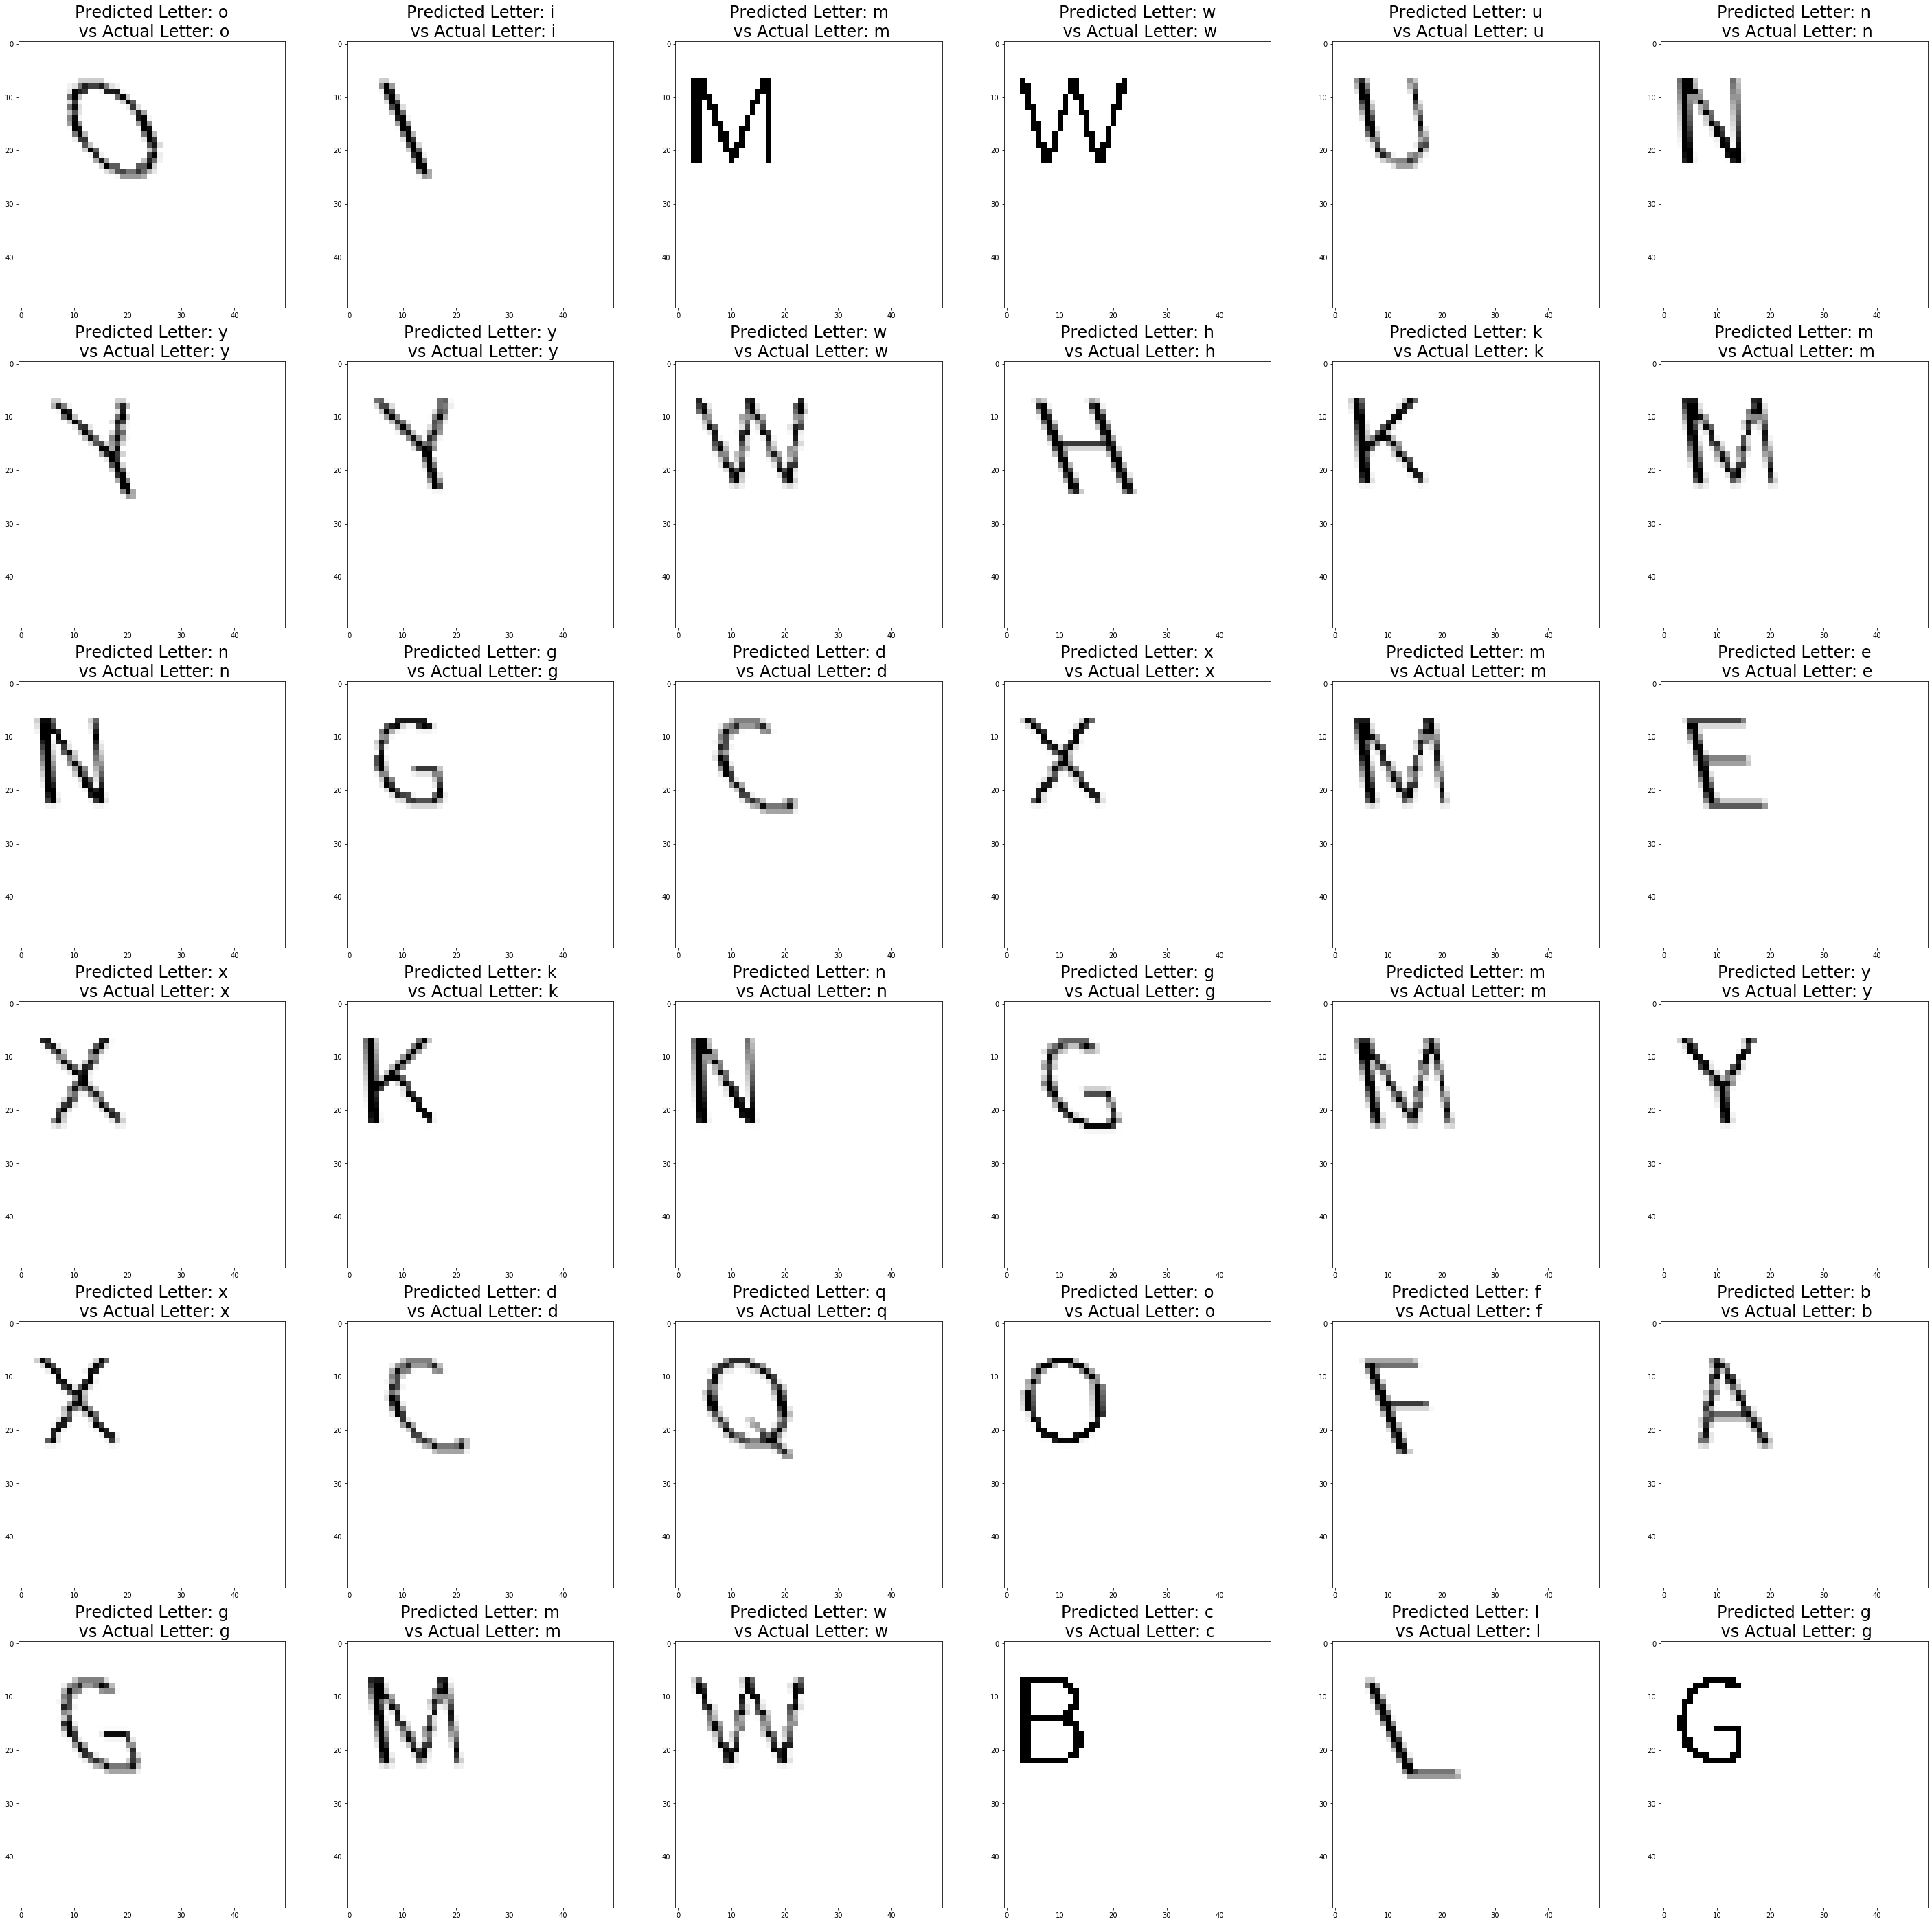

In [74]:
import random
import string

letters = list(string.ascii_lowercase)
ROWS = 6
COLUMNS = 6
fig, ax = plt.subplots(ROWS,COLUMNS, figsize=(50,50))

for row in range(ROWS):
    for column in range(COLUMNS):
        imgIndex = random.randint(0, len(X_test))
        image = X_test[imgIndex]
        image = image.reshape(50,50)
        ax[row,column].imshow(image,cmap='Greys')
        ax[row, column].set_title(f"Predicted Letter: {letters[np.argmax(predictions[imgIndex])+1]}\n vs Actual Letter: {letters[np.argmax(y_test[imgIndex])+1]}", fontSize=24)

### Letters Segmentation
Splitting image into indiviual letters. Breaking the problem down into a smaller problem: predicting letters.
- Segmenting the word to discover each of the letter withing it
    - Find contiguous sections of black pixel on the image
    - Extract them as sub-images

### CAPTCHAS Segmentation
- Extract letters from actual CAPTCHAS
- Label extracted letters

In [ ]:
def segment_image(image):
    """ Return list of sub-images letters from the original word image """
    
    # Detect where each letter is
    # Find connected sets of pixels that have same value
    # label takes image and return an array of the same shape as the original
    labeled_image = label(image > 0)
    
    subimages = []
    
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

In [ ]:
#
dataset = np.array([
    resize(segment_image(sample)[0], (20,20)) 
    for sample in dataset])

X = dataset.reshape((dataset.shape[0],
                     dataset.shape[1] * dataset.shape[2]))